In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points
import scipy.ndimage as ndi

%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


# Download benchmark data

In [8]:
brain = "8649"

base_dir = (
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain"
    + brain
    + "/"
)

In [9]:
if brain in brain2centers.keys():
    centers_train = brain2centers[brain][0]
    centers_val = brain2centers[brain][1]  # annotate z slice 25, 50 and 75
    print(f"{len(centers_train)} training samples, {len(centers_val)} val samples")
elif "val_info" in brain2paths[brain].keys():
    centers_val = json_to_points(brain2paths[brain]["val_info"]["url"])[
        brain2paths[brain]["val_info"]["layer"]
    ]
    print(f"{len(centers_val)} val samples")



if "train_info" in brain2paths[brain].keys():
    centers_train = json_to_points(brain2paths[brain]["train_info"]["url"])[
        brain2paths[brain]["train_info"]["layer"]
    ]
    print(f"{len(centers_train)} train samples")

mip = 0

dir = brain2paths[brain]["ab"]
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
dir = brain2paths[brain]["bg"]
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
dir = brain2paths[brain]["endo"]
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

25 points in val layer
3 points in train layer
25 val samples
25 points in val layer
3 points in train layer
3 train samples
fg shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]
bg shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]
endo shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]


In [ ]:
if "mask" in brain2paths[brain].keys():
    dir = brain2paths[brain]["mask"]
    vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

## View image

In [ ]:
dir = brain2paths[brain]["ab"]
vol_fg = CloudVolume(dir, parallel=1, mip=3, fill_missing=False)
print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
scale = [i / 1000 for i in vol_fg.resolution]
scale[2] = scale[2] * 4

In [ ]:
im = np.squeeze(np.array(vol_fg[:, :, :]))
from scipy.ndimage import zoom

new_array = zoom(im, (1, 1, 0.25))

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(new_array, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

### download training data

In [4]:
# for ilastik - blue/1 is axno yellow/0 is bg
# prediction model is /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/matt_benchmark_formal_brain3.ilp

isExist = os.path.exists(base_dir)
if not isExist:
    print(f"creating directory: {base_dir}")
    os.makedirs(base_dir)

dataset_to_save = "train"

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val
else:
    raise ValueError("invalid dataset")

for i, center in enumerate(centers):
    print(center)
    image_fg = vol_fg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_fg = image_fg[:, :, :, 0]

    image_bg = vol_bg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_bg = image_bg[:, :, :, 0]

    image_endo = vol_endo[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_endo = image_endo[:, :, :, 0]

    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)

    fname = f"{base_dir}{dataset_to_save}_{int(center[0])}_{int(center[1])}_{int(center[2])}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

[2569.829833984375, 2776.5, 142.07830810546875]


Downloading: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


[722.3624267578125, 2750.5, 994.06787109375]


Downloading: 100%|██████████| 4/4 [00:13<00:00,  3.38s/it]


[1068.611328125, 2796.5, 301.83416748046875]


Downloading: 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


## View data

In [ ]:
dset = "val"
num = "3"

fname = base_dir + dset + "_" + num + ".h5"

with h5py.File(fname, "r") as f:
    pred = f.get("image_2channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_image(image_endo)

In [ ]:
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "Labels.h5" in f]

num_pos_voxels = 0
for fname in files:
    f = h5py.File(fname, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2
    num_pos_voxels += np.sum(pos_labels)

print(num_pos_voxels)

# Check results

## Training

In [ ]:
brains = ["8613", "3", "4"]

for brain in brains:
    base_dir = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain"
        + brain
        + "/"
    )

    files = os.listdir(base_dir)
    files = [base_dir + f for f in files if "train" in f]
    files = [f for f in files if "Labels" in f]
    # need to filter for labels/probs fiiles

    total_pos = 0
    total_neg = 0
    for fname in files:
        f = h5py.File(fname, "r")
        im = np.array(f.get("exported_data"))
        pos = np.sum(im == 2)
        neg = np.sum(im == 1)

        total_pos += pos
        total_neg += neg

    print(f"{brain}: {total_pos}+/{total_neg}- total voxels")

## Validation

27 total validation subvolumes
Thresh: 0.02 --- Total prec.: 0.177 total rec.: 0.999 w/1198/26641 total pos/neg voxels. F-score: 0.3009
Thresh: 0.04 --- Total prec.: 0.247 total rec.: 0.997 w/1198/26641 total pos/neg voxels. F-score: 0.3954
Thresh: 0.06 --- Total prec.: 0.310 total rec.: 0.994 w/1198/26641 total pos/neg voxels. F-score: 0.4724
Thresh: 0.08 --- Total prec.: 0.371 total rec.: 0.987 w/1198/26641 total pos/neg voxels. F-score: 0.5392
Thresh: 0.10 --- Total prec.: 0.422 total rec.: 0.978 w/1198/26641 total pos/neg voxels. F-score: 0.5892
Thresh: 0.12 --- Total prec.: 0.476 total rec.: 0.962 w/1198/26641 total pos/neg voxels. F-score: 0.6370
Thresh: 0.14 --- Total prec.: 0.519 total rec.: 0.950 w/1198/26641 total pos/neg voxels. F-score: 0.6716
Thresh: 0.16 --- Total prec.: 0.560 total rec.: 0.937 w/1198/26641 total pos/neg voxels. F-score: 0.7013
Thresh: 0.18 --- Total prec.: 0.597 total rec.: 0.927 w/1198/26641 total pos/neg voxels. F-score: 0.7260
Thresh: 0.20 --- Total p

<matplotlib.legend.Legend object at 0x15b83ba30>

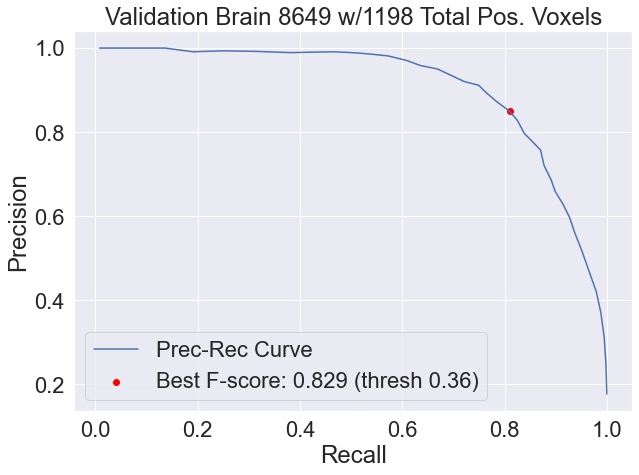

In [10]:
spacing = 0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")

for threshold in thresholds:
    true_pos_total = 0
    false_pos_total = 0
    true_labels_total = 0
    true_labels_total_neg = 0
    for fname_prob in files:

        fname_im = fname_prob[:-17] + ".h5"
        f = h5py.File(fname_im, "r")
        im = f.get("image_2channel")
        im_bg = im[0, :, :, :]
        im_fg = im[1, :, :, :]

        fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
        f = h5py.File(fname_lab, "r")
        gt = f.get("exported_data")
        gt = gt[0, :, :, :]
        pos_labels = gt == 2
        neg_labels = gt == 1

        f = h5py.File(fname_prob, "r")
        seg = f.get("exported_data")
        seg = seg[1, :, :, :]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        true_labels_neg = np.sum(neg_labels)
        true_labels_total_neg += true_labels_neg

    precision_total = true_pos_total / (true_pos_total + false_pos_total)
    recall_total = true_pos_total / true_labels_total
    fscore = 2 / (1 / precision_total + 1 / recall_total)
    print(
        f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total}/{true_labels_total_neg} total pos/neg voxels. F-score: {fscore:.4f}"
    )
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
        best_threshold = threshold
    precisions.append(precision_total)
    recalls.append(recall_total)
plt.plot(recalls, precisions, label="Prec-Rec Curve")
plt.scatter(
    [best_recall],
    [best_prec],
    c="red",
    label=f"Best F-score: {best_fscore:.3f} (thresh {best_threshold:.2f})",
)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title(f"Validation Brain {brain} w/{true_labels_total} Total Pos. Voxels")
plt.legend()

## Examine best threshold

In [11]:
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")


for i, fname_prob in enumerate(files):
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, "r")
    im = f.get("image_2channel")
    im_bg = im[0, :, :, :]
    im_fg = im[1, :, :, :]
    im_endo = im[2, :, :, :]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2
    neg_labels = gt == 1

    f = h5py.File(fname_prob, "r")
    seg = f.get("exported_data")
    seg = seg[1, :, :, :]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    true_labels = np.sum(pos_labels)
    true_labels_neg = np.sum(neg_labels)

    if true_labels == 0:
        recall = 1
    else:
        recall = true_pos/true_labels

    if true_pos + false_pos == 0:
        precision = 1
    else:
        precision = true_pos/(true_pos + false_pos)

    if precision < 0.8 or recall < 0.8:
        print(f"{i}) {fname_prob}: prec{precision} recall: {recall}")
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_fg, name=f"fg {i}")
        viewer.add_image(im_bg, name="bg")
        viewer.add_image(im_endo, name="endo")
        viewer.add_labels(mask, name="mask")
        viewer.add_labels(pos_labels+2*neg_labels, name="pos labels")



27 total validation subvolumes
0) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_1555_2142_596_Probabilities.h5: prec0.96875 recall: 0.6595744680851063
1) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_1896_1731_541_Probabilities.h5: prec0.8 recall: 0.15384615384615385
2) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_2919_529_1277_Probabilities.h5: prec0.0 recall: 1
3) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_3381_2398_1294_Probabilities.h5: prec0.0 recall: 1
6) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_906_3850_2109_Probabilities.h5: prec1.0 recall: 0.2786885245901639
8) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_2353_4116_1291_Probabilities.h5: prec0.0 recall: 1
9) /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_775_4829_2459_Pr

## Paper figure for all validation

10 total validation subvolumes for brain 8650
27 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590


<AxesSubplot:xlabel='Recall', ylabel='Precision'>

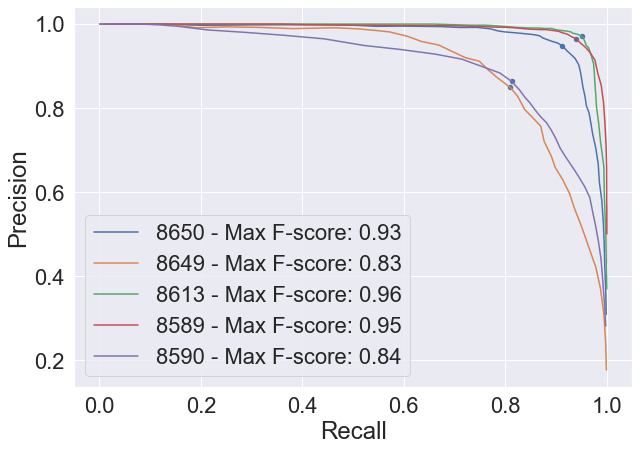

In [6]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

brain_ids = []
precisions = []
recalls = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain in brains:

    base_dir = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain"
        + brain
        + "/"
    )

    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore = 0

    files = os.listdir(base_dir)
    files = [base_dir + f for f in files if "val" in f]
    files = [f for f in files if "_Probabilities.h5" in f]
    fiiles = [f for f in files if "val" in f]

    print(f"{len(files)} total validation subvolumes for brain {brain}")

    for threshold in thresholds:
        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0
        true_labels_total_neg = 0
        for fname_prob in files:

            fname_im = fname_prob[:-17] + ".h5"
            f = h5py.File(fname_im, "r")
            im = f.get("image_2channel")
            im_bg = im[0, :, :, :]
            im_fg = im[1, :, :, :]

            fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
            f = h5py.File(fname_lab, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            f = h5py.File(fname_prob, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask = seg > threshold

            true_pos = np.sum(np.logical_and(mask, pos_labels))
            true_pos_total += true_pos
            false_pos = np.sum(np.logical_and(mask, gt == 1))
            false_pos_total += false_pos
            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels
            true_labels_neg = np.sum(neg_labels)
            true_labels_total_neg += true_labels_neg

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total

        precisions.append(precision_total)
        recalls.append(recall_total)
        brain_ids.append(brain)

        fscore = 2 / (1 / precision_total + 1 / recall_total)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision_total
            best_recall = recall_total
            best_threshold = threshold
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)
    best_fscores[brain] = best_fscore
for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample")
sns.scatterplot(x=best_recalls, y=best_precisions)

In [ ]:
sns.scatterplot(x=best_recalls, y=best_precisions, hue="red")

In [ ]:
json_to_points(
    "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=Tizkn7VMAv6B6Q",
    round=True,
)

### Examine best threshold

In [ ]:
for fname_prob in files:
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, "r")
    im = f.get("image_2channel")
    im_bg = im[0, :, :, :]
    im_fg = im[1, :, :, :]
    im_endo = im[2, :, :, :]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2

    f = h5py.File(fname_prob, "r")
    seg = f.get("exported_data")
    seg = seg[1, :, :, :]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / true_labels
    fscore = 2 / (1 / precision + 1 / recall)
    print(f"prec {precision} rec {recall} f {fscore}")
    if fscore < 0.75:
        print(fname_prob)
        name = fname_prob.split("/")[-1]
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg, name=name[:-17])
        viewer.add_image(im_fg)
        viewer.add_image(im_endo)
        viewer.add_labels(gt)
        viewer.add_labels(mask, name=f"p:{precision:.2f} r{recall:.2f}")

In [ ]:
json_to_points(
    "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=V1ZmxgI5NeFOaw",
    round=True,
)

# Make annotation layer

In [ ]:
dir = brain2paths[brain]["mask"]


info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint64",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol_bg.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol_bg.voxel_offset,  # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size=[128, 128, 2],  # units are voxels
    volume_size=vol_bg.volume_size,  # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

cannot write to https link, can write to s3 link

# View coronal heat maps

### setup atlas

In [2]:
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

# create vikram object
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

In [3]:
atlas_level = 5

atlas_level_nodes = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == atlas_level:
        atlas_level_nodes.append(node)
        print(f"{node}: {G.nodes[node]['name']}")

313: Midbrain
528: Cerebellar cortex
519: Cerebellar nuclei
703: Cortical subplate
477: Striatum
803: Pallidum
549: Thalamus
1097: Hypothalamus
771: Pons
354: Medulla
315: Isocortex
698: Olfactory areas
1089: Hippocampal formation


In [4]:
type2id = {"tph2 gad2": ["8650", "8649"],
"tph2 vglut3": ["8589", "8590", "8613"]}

vols_transformed_gad = [CloudVolume(brain2paths[id]["transformed_mask"]) for id in type2id["tph2 gad2"]]
vols_transformed_vglut = [CloudVolume(brain2paths[id]["transformed_mask"]) for id in type2id["tph2 vglut3"]]

atlas_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"
atlas = io.imread(atlas_path)
print(atlas.shape)

(1320, 800, 1140)


In [6]:
def find_atlas_level_label(label, atlas_level_nodes, atlas_level, G):
    if label == 0 or label not in G.nodes or G.nodes[label]["st_level"] <= atlas_level:
        return label
    else:
        counter = 0
        # find which region of atlas_level is parent
        for atlas_level_node in atlas_level_nodes:
            if label in nx.algorithms.dag.descendants(G, source=atlas_level_node):
                counter += 1
                atlas_level_label = atlas_level_node
        if counter == 0:
            preds = list(G.predecessors(label))
            if len(preds) != 1:
                raise ValueError(f"{len(preds)} predecessors of node {label}")
            atlas_level_label = find_atlas_level_label(preds[0], atlas_level_nodes, atlas_level, G)
            counter += 1
        if counter != 1:
            raise ValueError(f"{counter} atlas level predecessors of {label}")
        return atlas_level_label


def fold(image):
    half_width = np.round(image.shape[1]/2).astype(int)
    left = image[:,:half_width]
    right = image[:,half_width:]
    left = left + np.flip(right, axis=1)
    return left


new_labels = {}
for z in np.arange(100, 1300, 100):
    slice = atlas[z, :, :]
    newslice = np.copy(slice)
    for label in tqdm(np.unique(slice), desc=f"Relabeling in z={z}"):
        atlas_level_label = find_atlas_level_label(label, atlas_level_nodes, atlas_level, G)
        newslice[slice == label] = atlas_level_label
        if atlas_level_label not in new_labels.keys():
            if atlas_level_label in G.nodes:
                name = G.nodes[atlas_level_label]["name"]
            else:
                name = "??"
            new_labels[atlas_level_label] = name

    print(new_labels)

    labels = measure.label(newslice)
    borders = 0 * labels
    for label in tqdm(np.unique(labels), desc=f"Processing labels in z={z}"):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    v = napari.Viewer()
    #v.add_labels(newslice, scale = [10,10])

    #get projection data
    for volnum, vol_transformed_gad in enumerate(vols_transformed_gad):
        slice_gad = np.squeeze(vol_transformed_gad[z-10:z+10,:,:])
        slice_gad = ndi.gaussian_filter(slice_gad.astype(float), sigma=(3,3,3))[10,:,:]
        slice_gad[newslice == 0] = 0
        if volnum == 0:
            slice_gad_total = slice_gad
        else:
            slice_gad_total += slice_gad

    for volnum, vol_transformed_vglut in enumerate(vols_transformed_vglut):
        slice_vglut = np.squeeze(vol_transformed_vglut[z-10:z+10,:,:])
        slice_vglut = ndi.gaussian_filter(slice_vglut.astype(float), sigma=(3,3,3))[10,:,:]
        slice_vglut[newslice == 0] = 0
        if volnum == 0:
            slice_vglut_total = slice_vglut
        else:
            slice_vglut_total += slice_vglut

    #only show hemisphere
    slice_vglut_total /= np.amax(slice_vglut_total)
    slice_gad_total /= np.amax(slice_gad_total)

    slice_gad_total = fold(slice_gad_total)
    slice_vglut_total = fold(slice_vglut_total)
    borders = borders[:,:int(borders.shape[1]/2)]

    projections= np.stack([slice_gad_total,slice_vglut_total,0*slice_vglut_total], axis = -1)
    v.add_image(projections, rgb=True, scale = [10,10], name=f"vglut=green,gad2=red")
    v.add_labels(borders*2, scale = [10,10], name=f"z={z}")
    v.scale_bar.unit = "um"
    v.scale_bar.visible = True


Relabeling in z=1000: 100%|██████████| 80/80 [00:00<00:00, 280.55it/s]


{0: '??', 771: 'Pons', 313: 'Midbrain', 967: 'cranial nerves', 960: 'cerebellum related fiber tracts', 354: 'Medulla', 73: 'ventricular systems', 983: 'lateral forebrain bundle system', 315: 'Isocortex', 512: 'Cerebellum', 1089: 'Hippocampal formation', 1000: 'extrapyramidal fiber systems', 997: 'root', 528: 'Cerebellar cortex', 312782656: '??', 549009216: '??'}


Downloading: 100%|██████████| 1800/1800 [00:13<00:00, 130.55it/s]


## Registration

In [ ]:
# downsample
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_2.img"
im = io.imread(im_path)
print(im.shape)
print(np.unique(im))

im = im.astype("float")

im_ds = ndi.zoom(im, (0.4, 0.4, 0.4))
print(im_ds.shape)
print(np.unique(im_ds))

np.save(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_3_ds.npy",
    im_ds,
)

In [ ]:
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/axon_mask_1_0.tif"
im = io.imread(im_path)
print(im.shape)
print(np.sum(im))

In [ ]:
brain = "brain3"

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_3_ds.npy"
# im = np.load(im_path)
# print(im.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/axon_mask_3.tif"
# im_unreg = io.imread(im_path)
# print(im_unreg.shape)


im_path = (
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/"
    + brain
    + "/register/registered_1.img"
)
im_reg2 = io.imread(im_path)
print(im_reg2.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/" + brain + "/register/registered_3.img"
# im_reg3 = io.imread(im_path)
# print(im_reg3.shape)

# vol = CloudVolume(
#     "s3://open-neurodata/ara_2016/sagittal_10um/annotation_10um_2017", mip=0, use_https=True
# )
# print(vol.shape)
# atlas = vol[:,:,:,:]
# atlas = np.squeeze(atlas).T
# print(atlas.shape)
# len(np.unique(atlas))

im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/ara_10um.tif"
atlas = io.imread(im_path)
print(atlas.shape)

In [ ]:
smooth = ndi.gaussian_filter(im_reg2.astype("float"), sigma=3)
# smooth = ndi.zoom(smooth, (0.4,0.4,0.4))

In [ ]:
viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area="right")
# viewer.add_image(im)
viewer.add_image(smooth)
# viewer.add_image(im_reg2)
# viewer.add_image(im_reg3)
viewer.add_labels(atlas)
napari.run()

In [ ]:
for z in [180, 430, 680, 1030, 1280]:

    slice = atlas[:, :, z]
    slice_data = smooth[:, :, z]  # np.sum(im_reg[:,:,z], axis=2)
    mn = np.amin(slice_data)
    print(np.unique(slice_data))
    slice_data[slice == 0] = mn
    labels = measure.label(slice)
    # plt.imshow(labels)

    borders = 0 * labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    print(np.unique(borders))
    borders = borders.astype("float")
    borders_layer = np.zeros((borders.shape[0], borders.shape[1], 4))
    for rgba in range(borders_layer.shape[2]):
        borders_layer[:, :, rgba] = borders

    slice_data = ndi.rotate(slice_data, 270)
    plt.imshow(slice_data, cmap="inferno")
    borders_layer = ndi.rotate(borders_layer, 270)
    plt.imshow(borders_layer, cmap="gray")

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig("/Users/thomasathey/Desktop/" + str(z) + ".png", dpi=100)

# Atlas readout

In [2]:
volumes = {}
for x in tqdm(np.arange(0, vol_mask.shape[0], 128)):
    x2 = np.amin([x + 128, vol_mask.shape[0]])
    for y in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
        y2 = np.amin([x + 128, vol_mask.shape[1]])
        for z in tqdm(np.arange(0, vol_mask.shape[2], 128), leave=False):
            z2 = np.amin([x + 128, vol_mask.shape[2]])
            labels = vol_reg[x:x2, y:y2, z:z2]
            labels_unique = np.unique(labels)
            mask = vol_mask[x:x2, y:y2, z:z2]

            for unq in labels_unique:
                if unq in volumes.keys():
                    cur_vol = volumes[unq][1]
                    cur_total = volumes[unq][0]
                else:
                    cur_vol = 0
                    cur_total = 0
                cur_vol += np.sum(mask[labels == unq])
                cur_total += np.sum(labels == unq)
                volumes[unq] = [cur_total, cur_vol]

NameError: name 'vol_mask' is not defined

## Read quantification dictionary

In [3]:
brains = {
    # "3": "sert cre",
    # "4": "sert cre",
    "8613": "tph2 vglut3",
    # "8604": "tbd",
    "8650": "tph2 gad2",
    "8589": "tph2 vglut3",
    "8590": "tph2 vglut3",
    "8649": "tph2 gad2"
}
counts = {}
for gene in set(brains.values()):
    count = 0
    for brain in brains.keys():
        if brains[brain] == gene:
            count += 1
    counts[gene] = count


quantification_dicts = {}

for brain in brains.keys():
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/wholebrain_"
        + brain
        + ".pkl"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [4]:
regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

In [5]:
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

In [6]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain + " axon"] = 0
        G.nodes[node.id][brain + " total"] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + float(
                quantification_dict[key][1]
            )
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + float(
                quantification_dict[key][0]
            )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = (
                    G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                )
                G.nodes[parent][brain + " total"] = (
                    G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
                )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

Max level: 10
0
0
2343053.0
196340416.0
493480545.0
27103979712.0


## pandas + seaborn

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [8]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    #choose level here
    children = list(G.successors(region))
    children = [region]
    for child in children:
        for brain in quantification_dicts.keys():
            axon_vols.append(G.nodes[child][brain + " axon"] / totals[brain] * 100)
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"]
                    / G.nodes[child][brain + " total"]
                    * 100
                )

            gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])

d = {
    "Percent Total Axon Volume (%)": axon_vols,
    "Axon Density (%)": axon_denss,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex


ZeroDivisionError: float division by zero

## figure for paper

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Midbrain_tph2 vglut3 (n=3) vs. Midbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:4.000e-01 U_stat=5.000e+00
Hindbrain_tph2 vglut3 (n=3) vs. Hindbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:2.000e-01 U_stat=6.000e+00
Thalamus_tph2 vglut3 (n=3) vs. Thalamus_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:2.000e-01 U_stat=6.000e+00
Olfactory areas_tph2 vglut3 (n=3) vs. Olfactory areas_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:2.000e-01 U_stat=6.000e+00
Cerebral cortex_tph2 vglut3 (n=3) vs. Cerebral cortex_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_

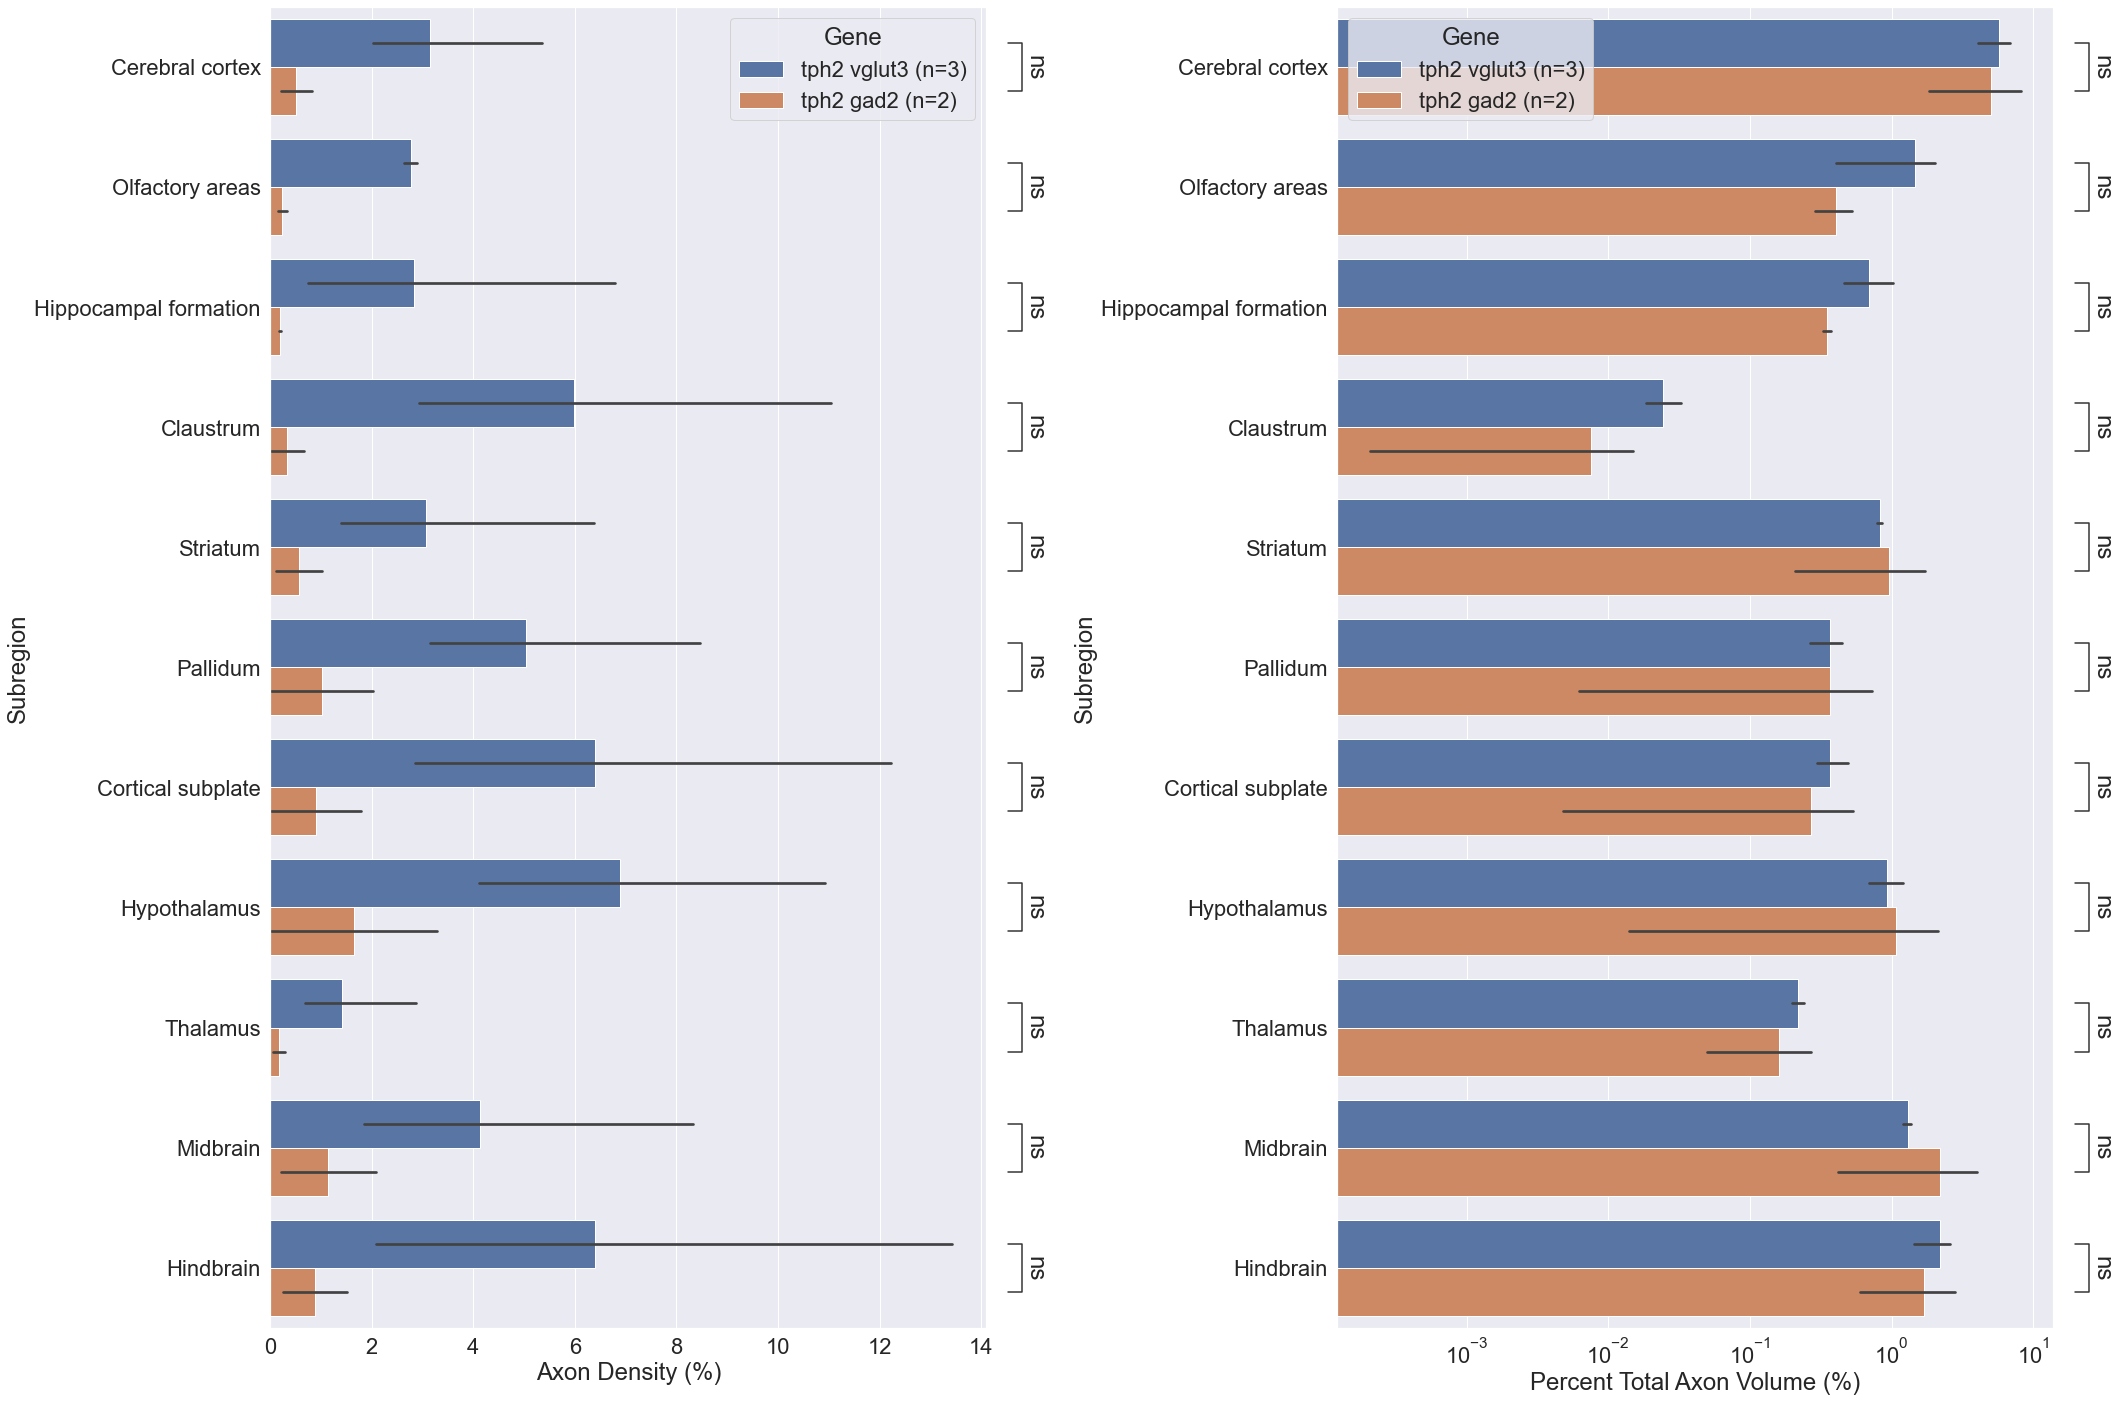

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(30, 20))
sns.set(font_scale=2)

test = "Mann-Whitney" 
#test = "t-test_ind"
correction = "fdr_by"

#density
fig_args = {
    "y": "Axon Density (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a,b) for idx, a in enumerate(genes) for b in genes[idx+1:]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Axon Density (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

strpplot = sns.barplot(ax=axes[0], orient="h", **fig_args)

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# percent total
fig_args = {
    "y": "Percent Total Axon Volume (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent Total Axon Volume (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

strpplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

## Compare to Allen

### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()